<a href="https://colab.research.google.com/github/Salma-Kassem/DeepLearning/blob/main/MovieRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Disclaimer: https://github.com/srp98/Movie-Recommender-using-RBM/blob/master/Recommender_System.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys, os
sys.path.append('/content/drive/My Drive/Colab Notebooks/RBM')
cur_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/RBM/'
print(cur_dir)
data_path = cur_dir + 'm1-1m/'
print(data_path)

/content/drive/My Drive/Colab Notebooks/RBM/
/content/drive/My Drive/Colab Notebooks/RBM/m1-1m/


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd


def set_model_parameters(hidden_units, visible_units):
    # Setting the models Parameters
    vb = tf.placeholder(tf.float32, [visible_units])  # Number of unique movies
    hb = tf.placeholder(tf.float32, [hidden_units])  # Number of features were going to learn
    w = tf.placeholder(tf.float32, [visible_units, hidden_units])  # Weight Matrix

    # Phase 1: Input Processing
    v0 = tf.placeholder("float", [None, visible_units])
    _h0 = tf.nn.sigmoid(tf.matmul(v0, w) + hb)  # Visible layer activation
    h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))  # Gibb's Sampling

    # Phase 2: Reconstruction
    _v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(w)) + vb)  # Hidden layer activation
    v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
    h1 = tf.nn.sigmoid(tf.matmul(v1, w) + hb)
    return v0, h0, v1, h1, w, vb, hb


def set_rbm_training_parameters(v0, h0, v1, h1, w, vb, hb):
    # Learning rate
    alpha = 1.0

    # Create the gradients
    w_pos_grad = tf.matmul(tf.transpose(v0), h0)
    w_neg_grad = tf.matmul(tf.transpose(v1), h1)

    # Calculate the Contrastive Divergence to maximize
    cd = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

    # Create methods to update the weights and biases
    update_w = w + alpha * cd
    update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
    update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

    # Set the error function, here we use Mean Absolute Error Function
    err = v0 - v1
    err_sum = tf.reduce_mean(err*err)
    return update_w, update_vb, update_hb, err_sum


def train_rbm(visible_units, hidden_units, epochs, batchsize, tr_list,
              update_w, update_vb, update_hb, w, vb, hb, v0, err_sum):
    # Current weight
    cur_w = np.zeros([visible_units, hidden_units], np.float32)
    # Current visible unit biases
    cur_vb = np.zeros([visible_units], np.float32)
    # Current hidden unit biases
    cur_hb = np.zeros([hidden_units], np.float32)
    # Previous weight
    prv_w = np.zeros([visible_units, hidden_units], np.float32)
    # Previous visible unit biases
    prv_vb = np.zeros([visible_units], np.float32)
    # Previous hidden unit biases
    prv_hb = np.zeros([hidden_units], np.float32)
    session = tf.Session()
    session.run(tf.global_variables_initializer())

    # Train RBM with 15 Epochs, with Each Epoch using 10 batches with size 100, After training print out the error by
    # epoch
    errors = []
    for i in range(epochs):
        for start, end in zip(range(0, len(tr_list), batchsize), range(batchsize, len(tr_list), batchsize)): # 0 32/ 32 64/ ...
            batch = tr_list[start:end]
            cur_w = session.run(update_w, feed_dict={v0: batch, w: prv_w, vb: prv_vb, hb: prv_hb})
            cur_vb = session.run(update_vb, feed_dict={v0: batch, w: prv_w, vb: prv_vb, hb: prv_hb})
            cur_hb = session.run(update_hb, feed_dict={v0: batch, w: prv_w, vb: prv_vb, hb: prv_hb})
            prv_w = cur_w
            prv_vb = cur_vb
            prv_hb = cur_hb
        errors.append(session.run(err_sum, feed_dict={v0: tr_list, w: cur_w, vb: cur_vb, hb: cur_hb}))
        print(errors[-1])
    return errors, session, prv_w, prv_vb, prv_hb


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
def recommend_movies(input_user, session, movies_df, merged_df, v0, w, vb, hb, prv_w, prv_vb, prv_hb):
    # Feeding in the User and Reconstructing the input
    hh0 = tf.nn.sigmoid(tf.matmul(v0, w) + hb)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(w)) + vb)
    feed = session.run(hh0, feed_dict={v0: input_user, w: prv_w, hb: prv_hb})
    rec = session.run(vv1, feed_dict={hh0: feed, w: prv_w, vb: prv_vb})

    # List the 20 most recommended movies for our mock user by sorting it by their scores given by our model.
    scored_movies_df_50 = movies_df
    scored_movies_df_50["Recommendation Score"] = rec[0]
    print(scored_movies_df_50.sort_values(["Recommendation Score"], ascending=False).head(20))

    """ Recommend User what movies he has not watched yet """

    # Find the mock user's UserID from the data
    print(merged_df.iloc[50])  # Result you get is UserID 150

    # Find all movies the mock user has watched before
    movies_df_50 = merged_df[merged_df['UserID'] == 150]
    print(movies_df_50.head())

    """ Merge all movies that our mock users has watched with predicted scores based on his historical data: """

    # Merging movies_df with ratings_df by MovieID
    merged_df_50 = scored_movies_df_50.merge(movies_df_50, on='MovieID', how='outer')

    # Dropping unnecessary columns
    merged_df_50 = merged_df_50.drop('List Index_y', axis=1).drop('UserID', axis=1)

    # Sort and take a look at first 20 rows
    print(merged_df_50.sort_values(['Recommendation Score'], ascending=False).head(20))

    """There are some movies the user has not watched and has high score based on our model. So, we can recommend
    them. """

In [ ]:
def load_and_format_movie_dataset():
    # Load movies dataset
    movies_df = pd.read_csv(data_path+'movies.dat', sep='::', header=None, engine='python', encoding='latin-1')

    # Load ratings dataset
    ratings_df = pd.read_csv(data_path+'ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')

    # Rename our columns
    movies_df.columns = ['MovieID', 'Title', 'Genre']
    ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
    # print(movies_df.head())
    # print(ratings_df.head())

    # Data formatting
    print('The Number of Movies in Dataset', len(movies_df))

    # We will use List Index to index movies instead of ID as the number
    # of movies is 3883 while the IDs range from 1 to 3952
    movies_df['List Index'] = movies_df.index
    # print(movies_df.head())

    # Merge movies_df with ratings_df by MovieID
    merged_df = movies_df.merge(ratings_df, on='MovieID')
    # Drop unnecessary columns
    merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genre', axis=1)
    # Display the result
    # print(merged_df.head())

    # Group up the Users by their user ID's
    user_group = merged_df.groupby('UserID')
    # print(user_group.head())
    return movies_df, merged_df, user_group


def create_training_list(movies_df, user_group):
    """
    Formatting the data into input for the RBM.
    Store the normalized users ratings into a list of lists called trX.
    """

    # Amount of users used for training
    amount_of_used_users = 1000

    # Creating the training list
    tr = []

    # For each user in the group
    for userID, curUser in user_group:

        # Create a temp that stores every movie's rating
        temp = [0]*len(movies_df)

        # For each movie in curUser's movie list
        for num, movie in curUser.iterrows():
            # Divide the rating by 5 and store it
            temp[movie['List Index']] = movie['Rating']/5.0

        # Add the list of ratings into the training list
        tr.append(temp)

        # Check to see if we finished adding in the amount of users for training
        if amount_of_used_users == 0:
            break
        amount_of_used_users -= 1
    return tr

The Number of Movies in Dataset 3883
Instructions for updating:
Use `tf.cast` instead.
0.12290428
0.08215014
0.06747797
0.059832662
0.05428019
0.04910417
0.046170816
0.04498992
0.044323783
0.04351028
0.04345249
0.04248262
0.04172993
0.04120401
0.040771164


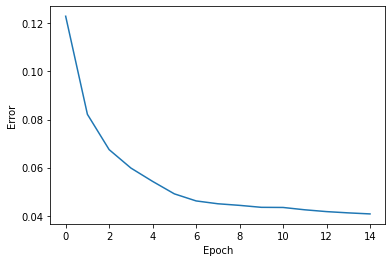

      MovieID                                      Title  \
2789     2858                     American Beauty (1999)   
604       608                               Fargo (1996)   
2327     2396                 Shakespeare in Love (1998)   
2928     2997                Being John Malkovich (1999)   
523       527                    Schindler's List (1993)   
1959     2028                 Saving Private Ryan (1998)   
3091     3160                            Magnolia (1999)   
3682     3751                         Chicken Run (2000)   
1575     1617                   L.A. Confidential (1997)   
2693     2762                    Sixth Sense, The (1999)   
3878     3948                    Meet the Parents (2000)   
315       318           Shawshank Redemption, The (1994)   
589       593           Silence of the Lambs, The (1991)   
257       260  Star Wars: Episode IV - A New Hope (1977)   
1245     1265                       Groundhog Day (1993)   
3509     3578                           

In [ ]:
import matplotlib.pyplot as plt


movies_df, merged_df, user_group = load_and_format_movie_dataset()
tr_list = create_training_list(movies_df, user_group)

hidden_units = 50
visible_units = len(movies_df)
v0, h0, v1, h1, w, vb, hb = set_model_parameters(hidden_units, visible_units)
epochs = 15
batchsize = 100
update_w, update_vb, update_hb, err_sum = set_rbm_training_parameters(v0, h0, v1, h1, w, vb, hb)
errors, tf_session, prv_w, prv_vb, prv_hb = train_rbm(visible_units, hidden_units, epochs, batchsize, tr_list,
                                                          update_w, update_vb, update_hb, w, vb, hb, v0, err_sum)
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

# Select the input User
input_user = [tr_list[50]]
recommend_movies(input_user, tf_session, movies_df, merged_df, v0, w, vb, hb, prv_w, prv_vb, prv_hb)